In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
wdir = Path('/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project')

import sys
sys.path.insert(0, str(wdir))

In [3]:
from les.les import les_desc_comp, les_dist_comp
import bento
import seaborn as sns
import numpy as np
from tqdm import tqdm
import leidenalg as lei
from scipy.linalg import eigh
from scipy.spatial.distance import squareform, pdist, cdist
import igraph as ig
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import polars as pl
from matplotlib.colors import to_hex
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as st
import torch
from les_pytorch.les import les_descriptor, les_distance
from functools import partial
from itertools import product
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [4]:
figdir = wdir/'figures'

### Get RNA Flow

In [5]:
adata = bento.io.read_h5ad(wdir/'data'/'petukhov2022_1scanpy.h5ad')

Saved to /cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/figures/mouse_ileum_cell_types.png


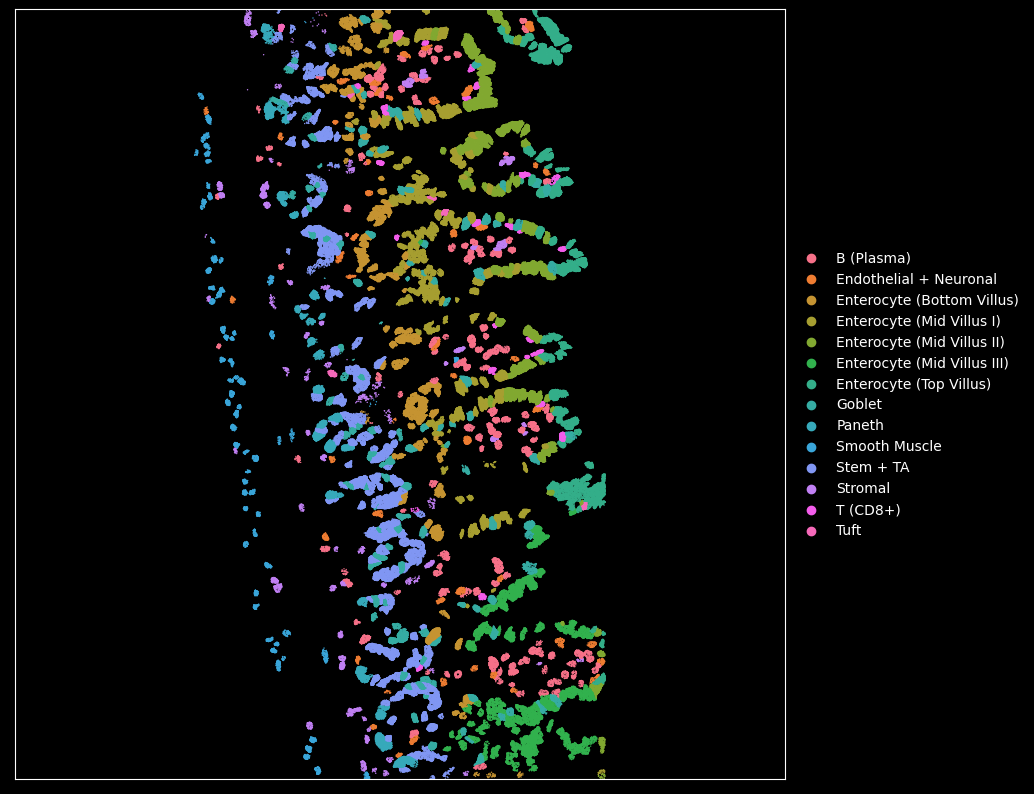

In [77]:
bento.pl.plot(adata, hue='leiden', height=10, shape_names=[], aspect=1.5, fname=figdir/'mouse_ileum_cell_types.png')

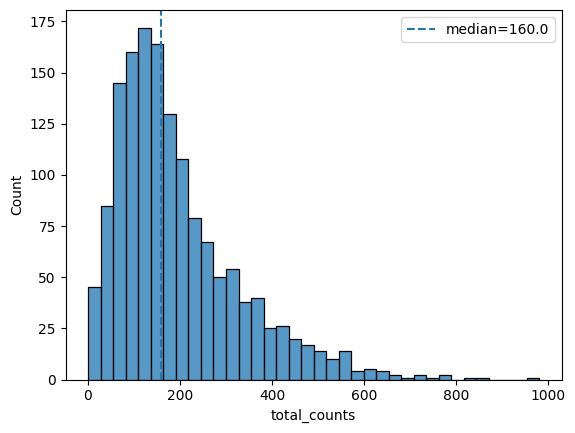

In [116]:
ax = sns.histplot(x=adata.obs['total_counts'])
ax.axvline(adata.obs['total_counts'].median(), ls='--', label=f'median={adata.obs["total_counts"].median()}')
ax.legend();

In [6]:
bento.tl.flow(adata, mode="point", radius=10, normalization='log', reduce=True)
adata.uns['points'].reset_index(drop=True, inplace=True)
min_pts = 92
gt_92_pts = adata.uns['points'].groupby('cell').transform('count')['x'] >= min_pts
points = adata.uns['points'][gt_92_pts].reset_index(drop=True)
points['gene'] = points['gene'].cat.remove_unused_categories()
points['cell'] = points['cell'].cat.remove_unused_categories()
points['nucleus'] = points['nucleus'].cat.remove_unused_categories()
flow = adata.uns['flow'][gt_92_pts]
obs = adata.obs[adata.obs.index.isin(points['cell'].unique())]
adata2 = adata[adata.obs.index.isin(points['cell'].unique())]

  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.
AnnData object modified:
    uns:
        + flow_genes, flow, flow_pca


In [7]:
# ss = StandardScaler()
# ss_flow = ss.fit_transform(flow.todense())

### Functions

In [9]:
def st_scale(x, k=7):
    # k=7 from Zelnik-Manor & Perona
    nn = NearestNeighbors(n_jobs=-1).fit(x)
    dists, _ = nn.kneighbors(x, n_neighbors=k)
    return dists[:, k-1]

def st_affinity(x, k=None):
    scales = st_scale(x) if k is None else st_scale(x, k)
    # fix 0 scales
    scales = np.maximum(scales, 1e-5)
    affinity = np.exp(- squareform(pdist(x, metric='sqeuclidean')) / scales / scales[:, None])
    return affinity

### LES on RNAflow

1. Get RNAflow (represent each point as gene counts of neighbors) $\to$ (c p g)
    - Can be grouped by cell and/or gene
2. For each cell, compute the LE descriptor (log eigenvalues) $\to$ (c p)
3. Cluster the cells using their LE descriptors (from cell-pairwise LES). (c c) $\to$ (c) clusters

This doesn't recover anything resembling cell types. Why?

- Needed to standardize the counts? Doesn't seem to make much of a difference.
- Because distances destroy gene-level information i.e. $d([1, 0], [0, 0]) = d([0, 1], [0, 0])$ but different genes are driving the difference. Gene-level information identifies cell type.

In [85]:
min_pts = 92
adata.uns['points'].reset_index(drop=True, inplace=True)
gt_92_pts = adata.uns['points'].groupby('cell').transform('count')['x'] >= min_pts
points = adata.uns['points'][gt_92_pts].reset_index(drop=True)
points['gene'] = points['gene'].cat.remove_unused_categories()
points['cell'] = points['cell'].cat.remove_unused_categories()
points['nucleus'] = points['nucleus'].cat.remove_unused_categories()
obs = adata.obs[adata.obs.index.isin(points['cell'].unique())]
adata2 = adata[adata.obs.index.isin(points['cell'].unique())]

In [91]:
# rads = [10, 20, 30]
# norms = [None, 'log', 'total']
# kernels = [None, st_affinity]
# for rad, norm, kernel in product(rads, norms, kernels):
#     _kernel = 'RBF' if kernel is None else 'stRBF'
#     fname = wdir/'data'/f'flow_rad={rad}_norm={norm}_kern={_kernel}_les_desc.npy'
#     if fname.exists(): continue
#     print(*fname.stem.split('_')[1:4])
    
#     bento.tl.flow(adata, mode="point", radius=rad, normalization=norm, reduce=True)
#     flow = adata.uns['flow'][gt_92_pts]
    
#     les_desc = []
#     for cell_id, g in tqdm(points.groupby('cell')):
#         les_desc.append(les_desc_comp(flow[g.index].toarray(), nev=min_pts, kernel_fn=kernel))
#     flow_les = np.stack(les_desc, axis=0)
#     np.save(fname, flow_les)

rad=10 norm=None kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.93it/s]


rad=10 norm=log kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.52it/s]


rad=10 norm=total kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.83it/s]


rad=10 norm=total kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:38<00:00,  4.00it/s]

rad=20 norm=None kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.55it/s]


rad=20 norm=None kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:38<00:00,  3.99it/s]


rad=20 norm=log kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:34<00:00, 32.29it/s]


rad=20 norm=log kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:36<00:00,  4.03it/s]


rad=20 norm=total kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.27it/s]


rad=20 norm=total kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:36<00:00,  4.02it/s]

rad=30 norm=None kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 29.55it/s]


rad=30 norm=None kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:39<00:00,  3.98it/s]


rad=30 norm=log kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:37<00:00, 30.05it/s]


rad=30 norm=log kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:38<00:00,  3.99it/s]


rad=30 norm=total kern=RBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [00:36<00:00, 30.69it/s]


rad=30 norm=total kern=stRBF


  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.


100%|██████████| 1112/1112 [04:42<00:00,  3.94it/s]


In [29]:
dfs = []
rads = [10, 20, 30]
norms = [None, 'log', 'total']
kernels = [None, st_affinity]
for rad, norm, kernel in product(rads, norms, kernels):
    _kernel = 'RBF' if kernel is None else 'stRBF'
    fname = wdir/'data'/f'flow_rad={rad}_norm={norm}_kern={_kernel}_les_desc.npy'
    flow_les = np.load(fname)
    
    norm = 'count' if norm == 'total' else norm
    
    # mean impute under/overflows
    if np.isnan(flow_les).any():
        rows, cols = np.isnan(flow_les).nonzero()
        print(fname, len(rows))
        for col in np.unique(cols):
            data = flow_les[:, col]
            data[np.isnan(data)] = np.nanmean(flow_les[:, col])
    
    cols = ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell_area', 'cell_density']
    
    lr = LinearRegression()
    lr.fit(flow_les, adata2.obs[cols])
    r2s = r2_score(adata2.obs[cols], lr.predict(flow_les), multioutput='raw_values')
    
    r2_df = pd.DataFrame({'variable': cols, 'r2': r2s})
    r2_df['radius'] = rad
    r2_df['normalization'] = str(norm)
    r2_df['kernel'] = _kernel

    lr = LogisticRegression(penalty='none')
    lr.fit(flow_les, adata2.obs[['leiden']])
    acc = lr.score(flow_les, adata2.obs[['leiden']])
    r2_df['cell_type_acc'] = acc
    
    dfs.append(r2_df)

df = pd.concat(dfs)
df.head()

/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=10_norm=total_kern=stRBF_les_desc.npy 1
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=20_norm=None_kern=stRBF_les_desc.npy 1
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=20_norm=log_kern=stRBF_les_desc.npy 1
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=20_norm=total_kern=stRBF_les_desc.npy 1
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=30_norm=None_kern=stRBF_les_desc.npy 15
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=30_norm=log_kern=stRBF_les_desc.npy 15
/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/data/flow_rad=30_norm=total_kern=stRBF_les_desc.npy 15


,variable,r2,radius,normalization,kernel,cell_type_acc
0,n_genes_by_counts,0.590367,10,None,RBF,0.30036
1,log1p_n_genes_by_counts,0.607505,10,None,RBF,0.30036
2,total_counts,0.769582,10,None,RBF,0.30036
3,log1p_total_counts,0.825996,10,None,RBF,0.30036
4,cell_area,0.577184,10,None,RBF,0.30036


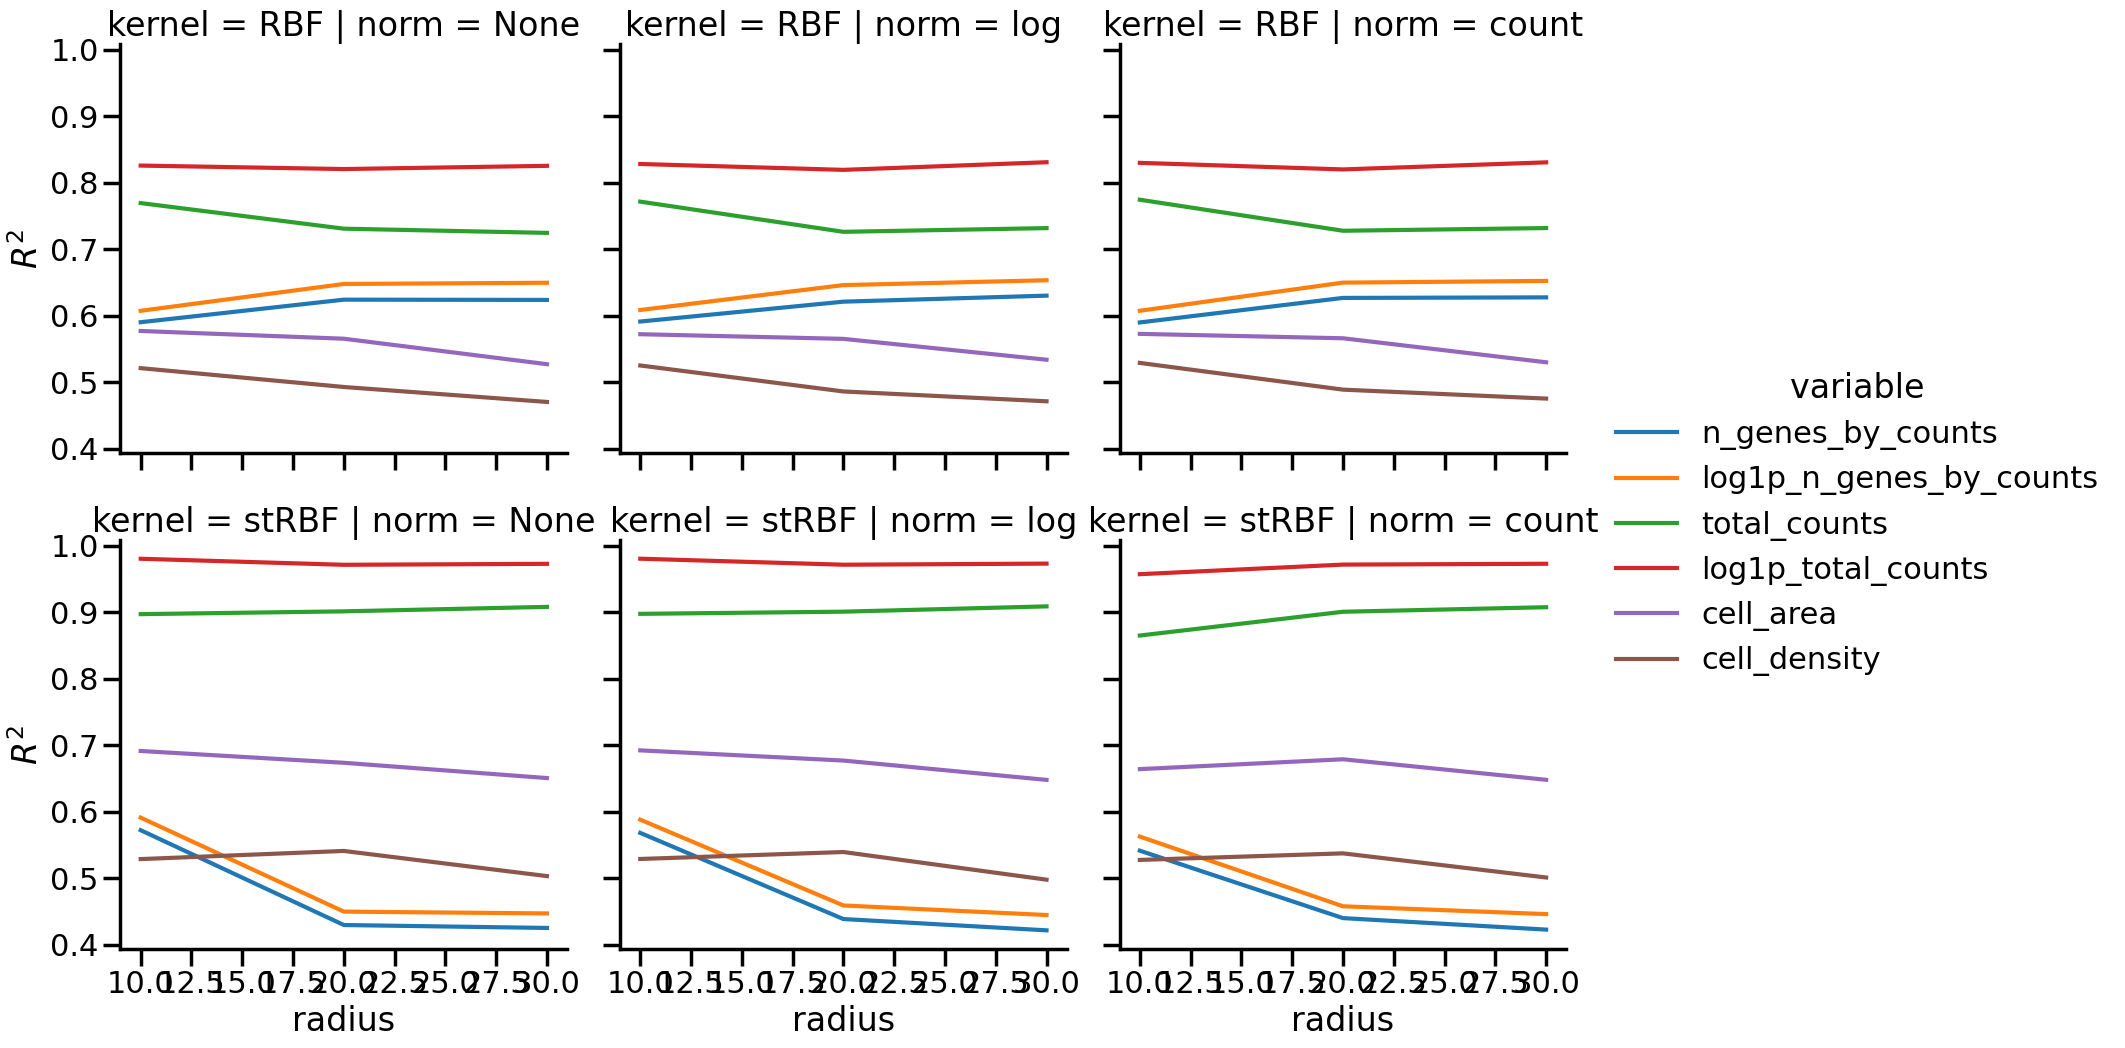

In [28]:
with sns.plotting_context('poster'):
    _df = df.rename(columns={'normalization': 'norm'})
    fgrid = sns.relplot(_df, x='radius', y='r2', hue='variable', col='norm', row='kernel', kind='line', height=5.5)
    fgrid.set(ylabel=r'$R^2$')
    fgrid.tight_layout()
    fgrid.savefig(figdir/'cell_vars_r2.png', dpi=300)

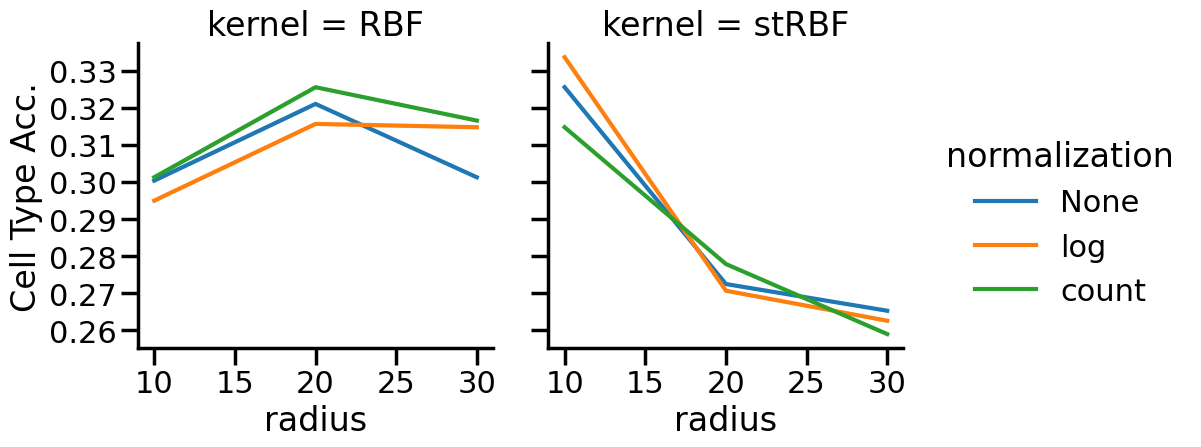

In [26]:
with sns.plotting_context('poster'):
    fgrid = sns.relplot(df.drop(columns='variable').drop_duplicates(), x='radius', y='cell_type_acc', hue='normalization', col='kernel', kind='line')
    fgrid.set(ylabel='Cell Type Acc.')
    fgrid.tight_layout()
    fgrid.savefig(figdir/'cell_types_acc.png', dpi=300)

In [59]:
df.loc[
    (df['kernel'] == 'stRBF')
    & (df['normalization'] == 'None')
    & (df['radius'] == 10)
]

,variable,r2,radius,normalization,kernel,cell_type_acc
0,n_genes_by_counts,0.572024,10,None,stRBF,0.32554
1,log1p_n_genes_by_counts,0.590938,10,None,stRBF,0.32554
2,total_counts,0.897044,10,None,stRBF,0.32554
3,log1p_total_counts,0.980377,10,None,stRBF,0.32554
4,cell_area,0.691194,10,None,stRBF,0.32554
5,cell_density,0.528565,10,None,stRBF,0.32554


In [63]:
df.drop(columns=['variable', 'r2']).drop_duplicates().sort_values('cell_type_acc', ascending=False)

,radius,normalization,kernel,cell_type_acc
0,10,log,stRBF,0.333633
0,10,None,stRBF,0.325540
0,20,count,RBF,0.325540
0,20,None,RBF,0.321043
0,30,count,RBF,0.316547
0,20,log,RBF,0.315647
0,30,log,RBF,0.314748
0,10,count,stRBF,0.314748
0,10,count,RBF,0.301259
0,30,None,RBF,0.301259


In [31]:
fname = wdir/'data'/'flow_rad=10_norm=None_kern=stRBF_les_desc.npy'
flow_les = np.load(fname)

In [32]:
flow_les = pd.DataFrame(flow_les, index=adata2.obs.index)

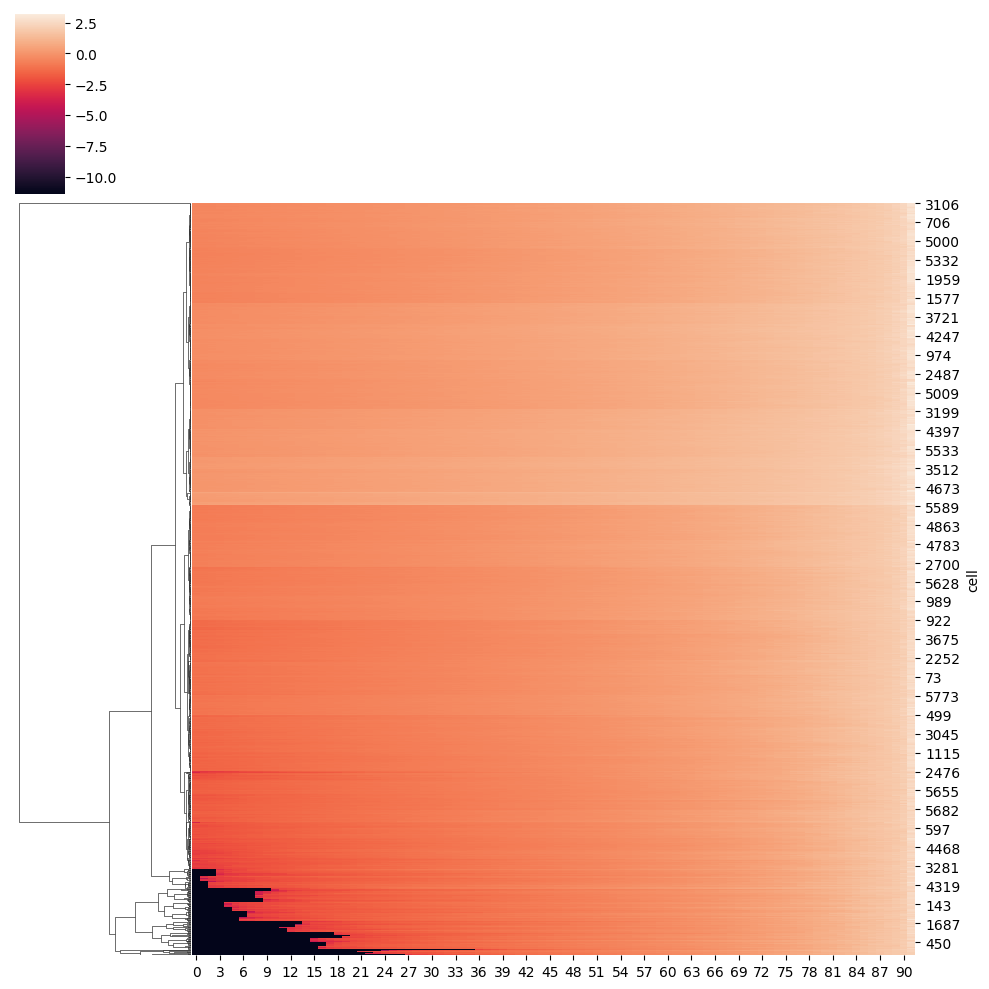

In [36]:
sns.clustermap(flow_les, col_cluster=False)

In [38]:
flow_les.min()

0    -11.417615
1    -11.417615
2    -11.417615
3    -11.417615
4    -11.417615
        ...    
87     1.300429
88     1.518209
89     1.610225
90     1.729605
91     2.017318
Length: 92, dtype: float64

In [39]:
arr = (flow_les.values < -10).sum(1)
adata2.obs['connectivity'] = arr

Trying to set attribute `.obs` of view, copying.


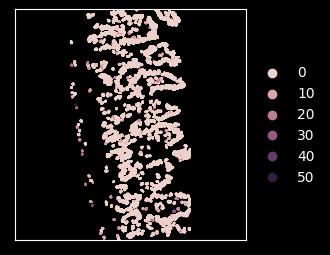

In [40]:
bento.pl.plot(adata2, hue='connectivity', shape_names=[])

In [12]:
adata2.obsm['X_flow_les'] = flow_les

In [13]:
adata2.obs['les_0'] = flow_les[:, 0]
adata2.obs['les_1'] = flow_les[:, 1]
adata2.obs['les_2'] = flow_les[:, 2]

In [110]:
flow_les_0_1 = ((flow_les - flow_les.min(0))/(flow_les.max(0) - flow_les.min(0)))
flow_les_hex = np.array([to_hex(v) for v in flow_les_0_1[:, -3:]])
adata2.obs['les_012_hex'] = flow_les_hex

Trying to set attribute `.obs` of view, copying.


In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='none')
lr.fit(flow_les, adata2.obs[['leiden']])
acc = lr.score(flow_les, adata2.obs[['leiden']])
acc

0.33363309352517984

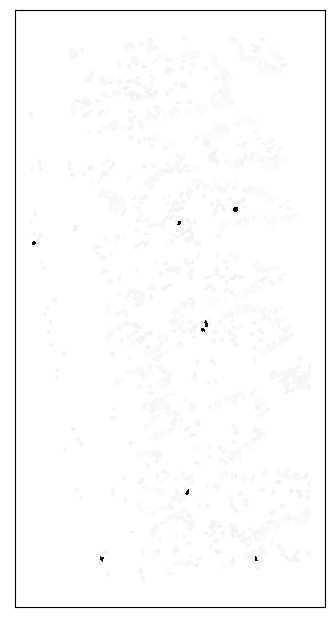

In [111]:
# with plt.style.context('dark_background'), sns.plotting_context('talk'):
fig, ax = plt.subplots(figsize=(4, 10))
gpd.GeoDataFrame(adata2.obs, geometry='cell_shape').plot(color=flow_les_hex, ax=ax)
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [129]:
# bento.pl.plot(adata2, kind='scatter', hue='total_counts', height=10, shape_names=[])

In [130]:
# bento.pl.plot(adata2, kind='scatter', hue='cell_density', height=10, shape_names=[])

In [41]:
pdists = cdist(flow_les, flow_les)

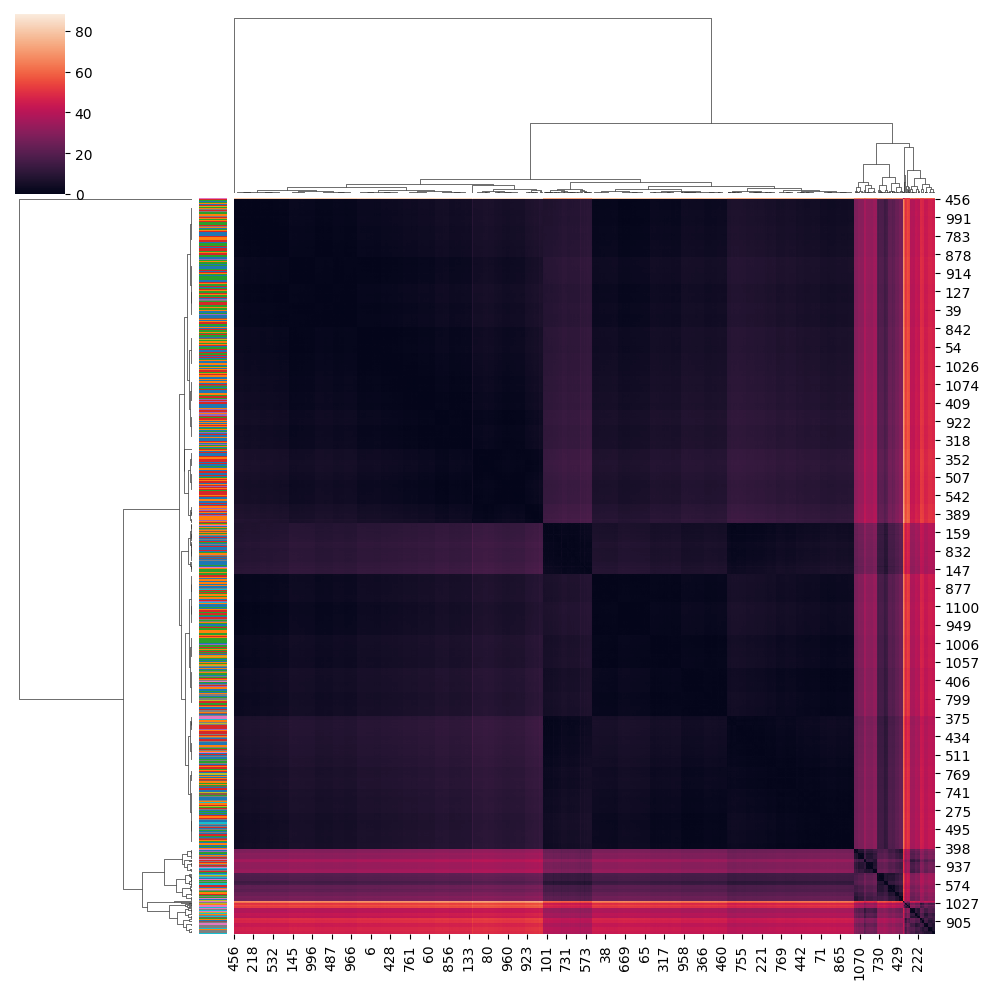

In [42]:
row_colors = obs['leiden'].astype(str).map(dict(zip(obs['leiden'].unique(), sns.color_palette('tab10', obs['leiden'].nunique()))))
sns.clustermap(pdists, row_colors=row_colors.to_numpy())

In [57]:
len(adata2.obs['leiden'].cat.categories)

14

In [53]:
clusters = KMeans(n_clusters=4).fit_predict(flow_les)
adata2.obs['kmeans'] = clusters
adata2.obs['kmeans'] = adata2.obs['kmeans'].astype('category')
bento.pl.plot(adata2, hue='kmeans', height=10, palette='tab10', shape_names=[], fname=figdir/'k=4_kmeans_les.png')

Saved to /cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project/figures/k=14_kmeans_les.png


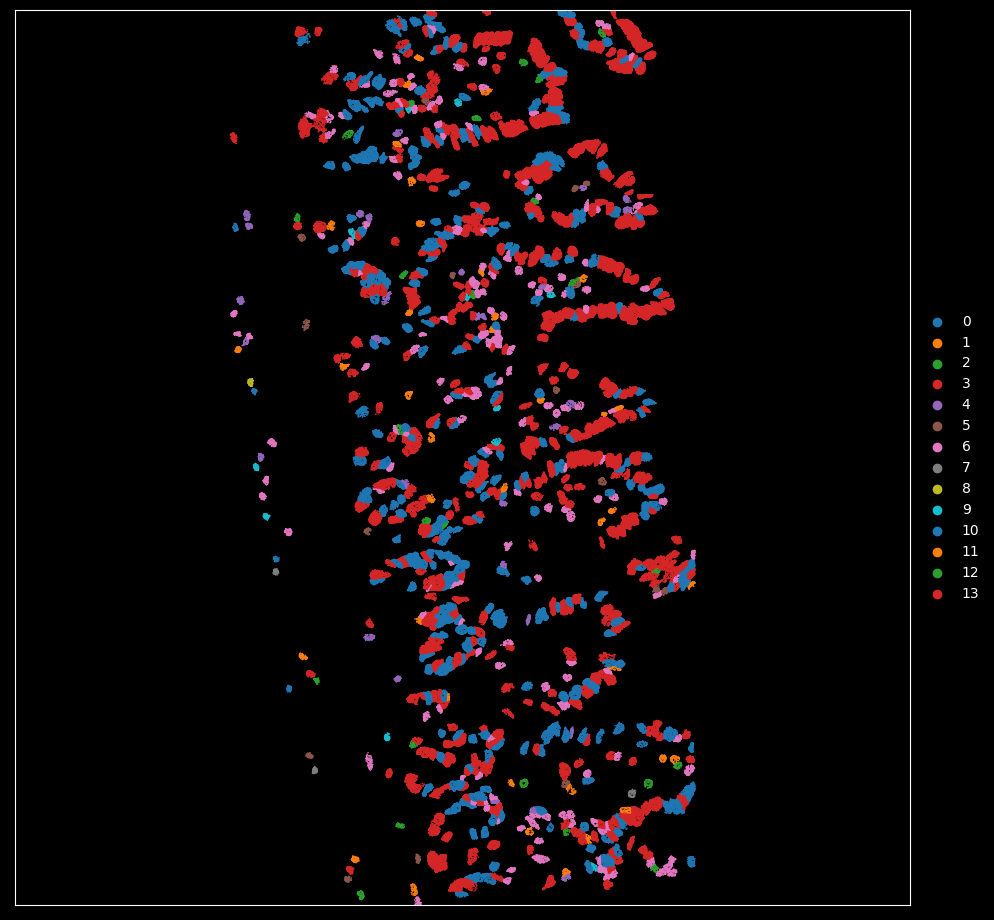

In [58]:
clusters = KMeans(n_clusters=14).fit_predict(flow_les)
adata2.obs['kmeans'] = clusters
adata2.obs['kmeans'] = adata2.obs['kmeans'].astype('category')
bento.pl.plot(adata2, hue='kmeans', height=10, palette='tab10', shape_names=[], fname=figdir/'k=14_kmeans_les.png')

In [104]:
clusters = lei.find_partition(
    ig.Graph.Weighted_Adjacency(pdists, mode='undirected'),
    lei.RBConfigurationVertexPartition,
    resolution_parameter=1.000001,
    n_iterations=5
)
clusters = np.array(clusters.membership)
len(np.unique(clusters))

1

In [106]:
cmap = dict(zip(np.unique(clusters), sns.color_palette('tab10', len(np.unique(clusters)))))
sorter = np.argsort(clusters)
sns.clustermap(pdists[sorter][:, sorter], row_colors=[[cmap[c] for c in clusters[sorter]], row_colors.to_numpy()[sorter]], row_cluster=False, col_cluster=False)

### LES on each gene separately

1. For each gene and cell (g c), get LE descriptor using (x y) coordinates. (g c p d) $\to$ (g c p)
    - where p = points, d = dimensionality (2, for x & y)
2. For each gene, compute the LE distance between all cells. $\to$ (g c c)
    - **This fails because some genes are not expressed in all cells.** i.e. There are no genes expressed in all cells, so the (g c c) tensor can't exist.
3. Compute multiplex Leiden clusters, letting each gene represent a different edge type. $\to$ (c)

In [16]:
pl_points = pl.from_pandas(points)

In [17]:
def les_desc_wrapper(g: pl.DataFrame, cols, kernel_fn_args=None):
    desc = les_desc_comp(g[cols].to_numpy(), kernel_fn=st_affinity, kernel_fn_args=kernel_fn_args)
    df = pl.DataFrame(desc.reshape(1, -1))
    df = df.select([
        pl.lit(g[0, 'gene']).alias('gene'),
        pl.lit(g[0, 'cell']).alias('cell'),
        pl.concat_list(pl.all()).alias('les_desc')
    ])
    return df

In [18]:
gene_cell_desc = (
    pl_points
    .filter(pl.count('x').over(['cell', 'gene']) > 10)
    .groupby(['cell', 'gene'])
    .apply(partial(les_desc_wrapper, cols=['x', 'y']))
)

In [19]:
gene_cell_desc = gene_cell_desc.select(['gene', 'cell']).with_row_count().join(
    gene_cell_desc['les_desc']
    .arr.slice(0, 11)
    .arr.to_struct(name_generator=lambda idx: f'eigval_{idx}')
    .struct.to_frame()
    .with_row_count(),
    on='row_nr'
).drop('row_nr')

In [153]:
gene_cell_desc.head()

gene,cell,eigval_0,eigval_1,eigval_2,eigval_3,eigval_4,eigval_5,eigval_6,eigval_7,eigval_8,eigval_9,eigval_10
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Txndc5""","""3771""",-11.417615,-11.417615,-6.920953,-5.993372,-4.766842,-3.532603,-3.298572,-3.133015,-2.756851,-2.235566,-2.042816
"""Clca3b""","""2059""",-9.246416,-7.02751,-5.260122,-2.949672,-2.495562,-1.779632,-0.997964,-0.113154,0.488863,0.891388,1.67891
"""Klk1""","""2137""",-6.282178,-5.601094,-4.91043,-4.623321,-3.794047,-3.182092,-2.748802,-2.389695,-1.285194,-0.99647,-0.747395
"""Neat1""","""407""",-11.417615,-11.417615,-9.992676,-4.425952,-3.966419,-3.332609,-2.711683,-2.295481,-0.933038,-0.778498,0.007019
"""Apob""","""5107""",-11.417615,-11.417615,-11.417615,-11.417615,-11.417615,-11.417615,-11.417615,-8.348805,-7.48436,-7.253035,-6.118231


In [40]:
gene_cell_desc['gene'].value_counts()

gene,counts
str,u32
"""Cps1""",321
"""Lrmp""",8
"""Net1""",73
"""Clca3b""",371
"""Slc12a2""",98
"""Sox10""",1
"""Kit""",41
"""Neat1""",861
"""Klk1""",56


### LES the whole way down

1. For each gene and cell (g c), get LE descriptor using (x y) coordinates. (g c p d) -> (g c p)
2. For each cell, compute the LE distance between all genes, and the LE descriptor of each cell. -> (c g g) -> (c g)
3. Compute stuff with that.

In [20]:
cell_desc = (
    gene_cell_desc
    .filter(pl.col('gene').count().over('cell') >= 4)
    .groupby('cell')
    .apply(partial(les_desc_wrapper, cols=[f'eigval_{i}' for i in range(10)], kernel_fn_args={'k': 4}))
)

In [21]:
cell_desc = cell_desc.select(['cell']).with_row_count().join(
    cell_desc['les_desc']
    .arr.slice(0, 4)
    .arr.to_struct(name_generator=lambda idx: f'eigval_{idx}')
    .struct.to_frame()
    .with_row_count(),
    on='row_nr'
).drop('row_nr')

In [60]:
adata3 = adata2[cell_desc['cell'].to_numpy()]

In [45]:
cell_les = cell_desc.head()

cell,eigval_0,eigval_1,eigval_2,eigval_3
str,f64,f64,f64,f64
"""194""",-1.898004,-1.575421,-0.793261,-0.414765
"""1952""",-5.355012,-3.294099,-1.328408,-0.957993
"""5595""",-2.185733,-1.863372,-1.234698,-0.824876
"""1759""",-2.620637,-2.43663,-1.307842,-0.972709
"""3687""",-3.230814,-1.481753,-1.458482,-1.162427


In [31]:
_cell_desc = cell_desc.select(pl.exclude('cell')).to_numpy()
cell_dists = cdist(_cell_desc, _cell_desc)

In [47]:
cell_desc_0_1 = ((_cell_desc - _cell_desc.min(0))/(_cell_desc.max(0) - _cell_desc.min(0)))
cell_desc_hex = np.array([to_hex(v) for v in cell_desc_0_1[:, :3]])
adata3.obs['les_012_hex'] = cell_desc_hex

Trying to set attribute `.obs` of view, copying.


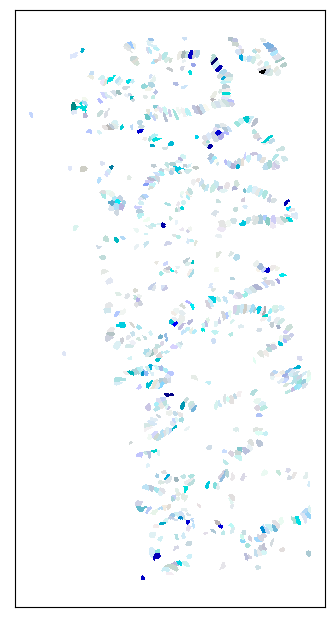

In [48]:
# with plt.style.context('dark_background'), sns.plotting_context('talk'):
fig, ax = plt.subplots(figsize=(4, 10))
gpd.GeoDataFrame(adata3.obs, geometry='cell_shape').plot(color=cell_desc_hex, ax=ax)
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [53]:
import pandas as pd

In [62]:
(
    adata3
        .obs[['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell_area', 'cell_density']]
)

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,cell_area,cell_density
cell,,,,,,
194,50,3.931826,302.0,5.713733,6960.0,0.043391
1952,42,3.761200,359.0,5.886104,6388.0,0.056199
5595,43,3.784190,464.0,6.142037,8732.0,0.053138
1759,27,3.332205,222.0,5.407172,5776.0,0.038435
3687,45,3.828641,333.0,5.811141,7296.0,0.045641
...,...,...,...,...,...,...
966,40,3.713572,217.0,5.384495,5764.0,0.037647
5363,41,3.737670,279.0,5.634789,6852.0,0.040718
5530,33,3.526361,272.0,5.609472,5284.0,0.051476


In [65]:
st.pearsonr(adata3.obs['log1p_total_counts'], _cell_desc[:, 0])

PearsonRResult(statistic=-0.5597122914437132, pvalue=1.576277646426606e-64)

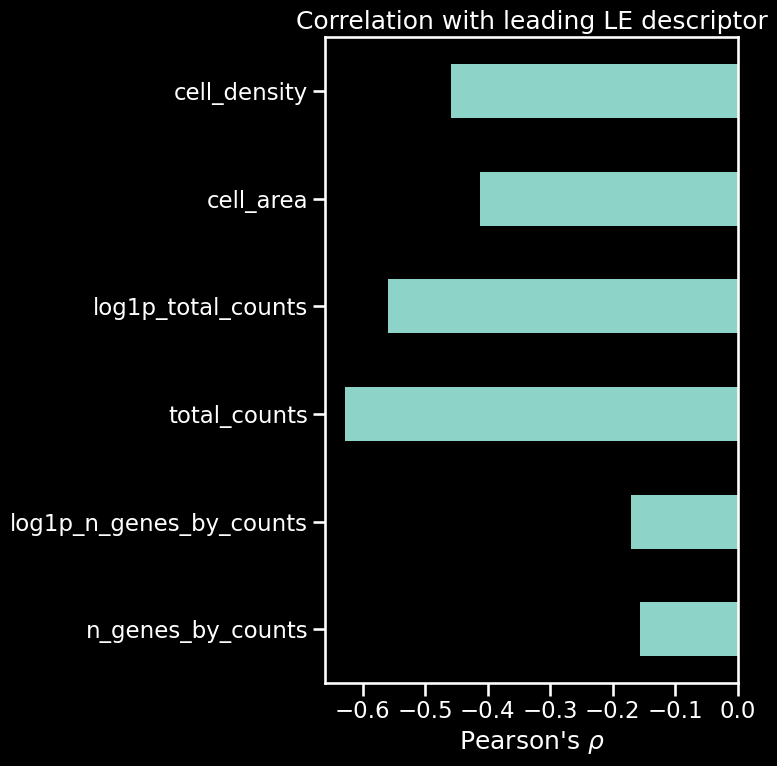

In [71]:
with plt.style.context('dark_background'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8,8))
    (
        adata3
        .obs[['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell_area', 'cell_density']]
        .corrwith(pd.Series(_cell_desc[:, 0], name='les_0', index=adata3.obs.index))
        .plot(kind='barh', ax=ax)
    )
    ax.set(title='Correlation with leading LE descriptor', xlabel=r"Pearson's $\rho$")
    fig.tight_layout()
    # fig.savefig(figdir/'les_0_correlations.png', dpi=300);

In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='none')
lr.fit(_cell_desc, adata3.obs[['leiden']])
acc = lr.score(_cell_desc, adata3.obs[['leiden']])
acc

0.19270833333333334

In [41]:
row_colors = adata3.obs['leiden'].astype(str).map(dict(zip(adata3.obs['leiden'].unique(), sns.color_palette('tab10', adata3.obs['leiden'].nunique()))))

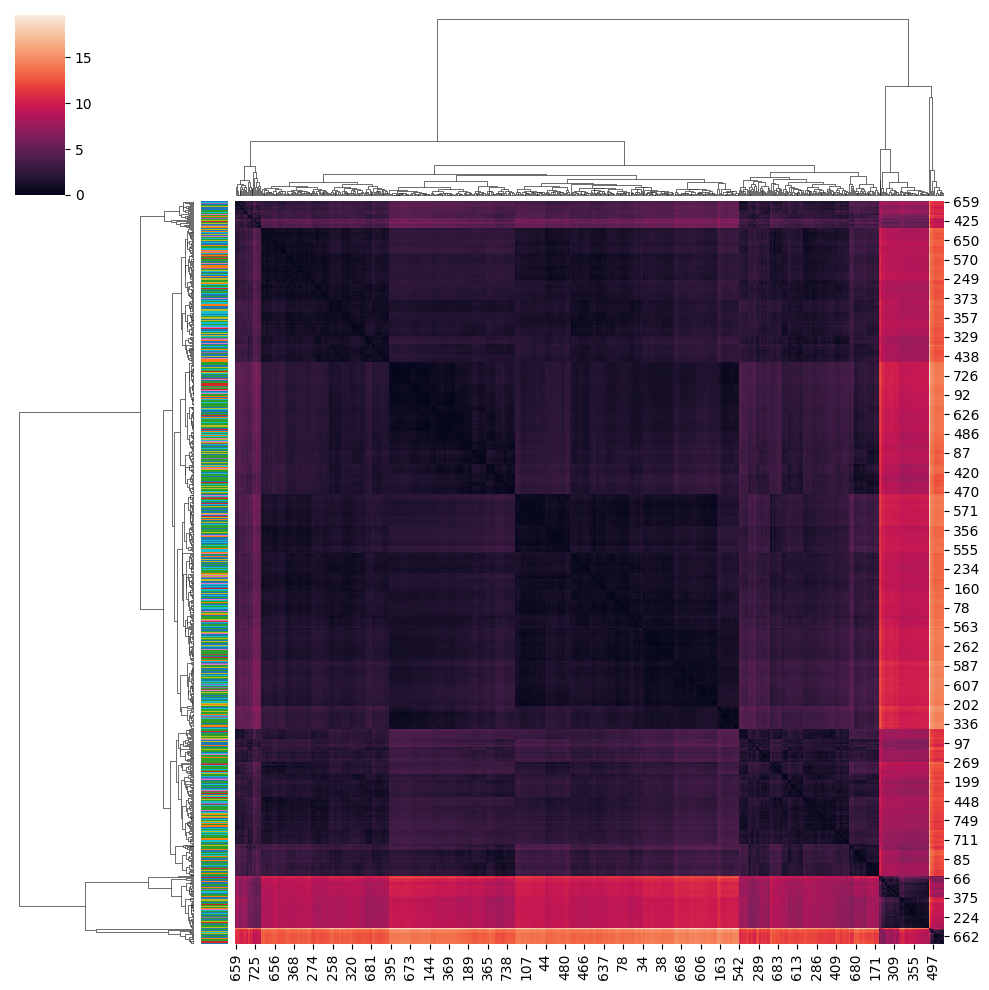

In [42]:
sns.clustermap(cell_dists, row_colors=row_colors.to_numpy());

In [34]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=5).fit_predict(cell_dists)

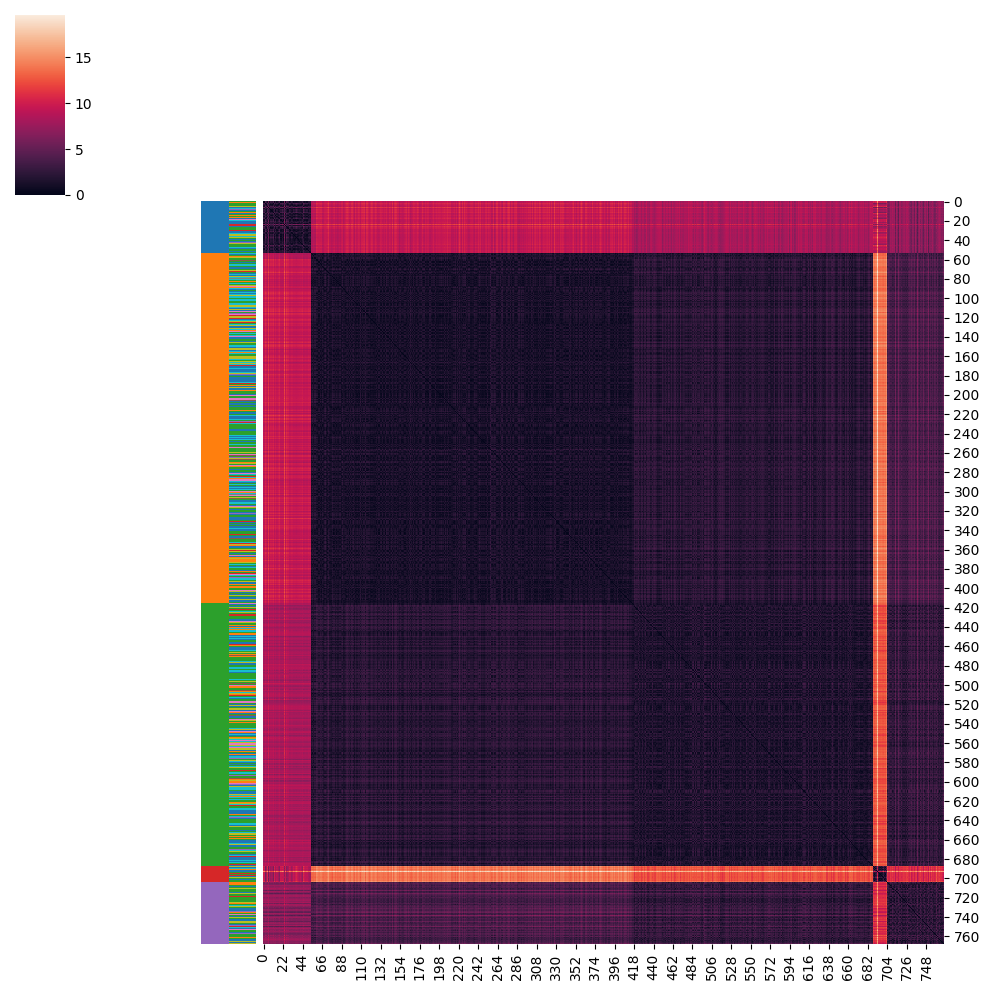

In [43]:
cmap = dict(zip(np.unique(clusters), sns.color_palette('tab10', len(np.unique(clusters)))))
sorter = np.argsort(clusters)
sns.clustermap(cell_dists[sorter][:, sorter], row_colors=[[cmap[c] for c in clusters[sorter]], row_colors.to_numpy()[sorter]], row_cluster=False, col_cluster=False);